# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [3]:
!pip install lightgbm
!pip install catboost

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('autos.csv')

display(df.info())
display(df.head())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


##### Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

##### Целевой признак
* Price — цена (евро)

### Предобработка данных

In [7]:
df.columns = df.columns.str.lower().str.strip()
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [8]:
df_features = df[['price',
                'vehicletype',
                'registrationyear',
                'gearbox',
                'power',
                'model',
                'kilometer',
                'fueltype',
                'brand',
                ]]
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
dtypes: int64(4), object(5)
memory usage: 24.3+ MB


In [9]:
print("Количество дубликатов =", df_features.duplicated().sum())
df_features = df_features.drop_duplicates()
print("Дубликаты обработаны. Их количество =", df_features.duplicated().sum())

Количество дубликатов = 56105
Дубликаты обработаны. Их количество = 0


In [10]:
df_features.isna().sum()

price                   0
vehicletype         33783
registrationyear        0
gearbox             17052
power                   0
model               18169
kilometer               0
fueltype            30375
brand                   0
dtype: int64

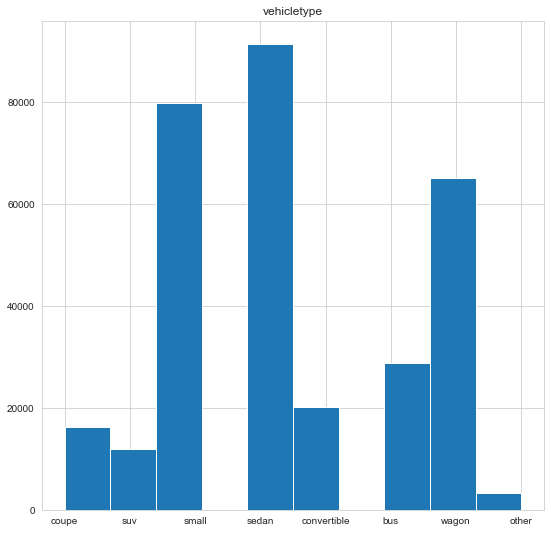

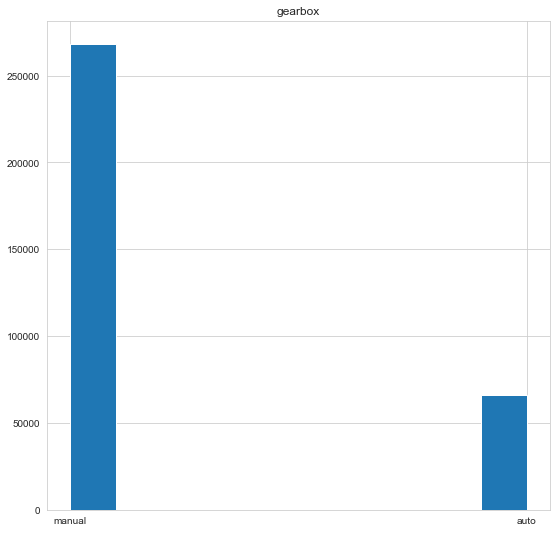

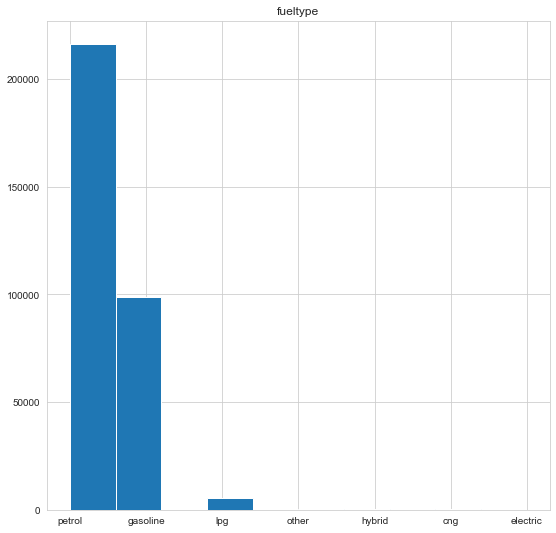

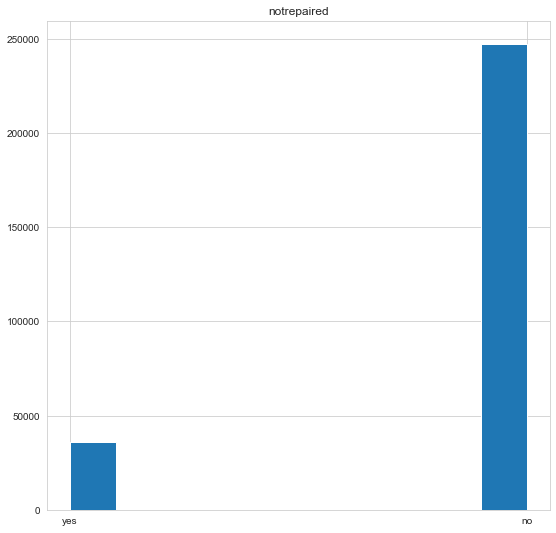

In [61]:
missing_col = df[['vehicletype', 'gearbox', 'fueltype', 'notrepaired']]
for column in missing_col:
    df[column].hist(figsize=(9,9))
    plt.title(column)
    plt.show()

In [12]:
df_features = df_features.fillna("unknown")
df_features.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
dtype: int64

Посмотрим на значения в количественных признаках.

In [55]:
num_features = ["price", "registrationyear", "power", "kilometer"]

df_features[num_features].describe()

,price,registrationyear,power,kilometer
count,298264.000000,298264.000000,298264.000000,298264.000000
mean,4558.398962,2004.472156,111.519396,126632.178205
std,4592.947262,94.215886,204.393630,38896.257879
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2850.000000,2003.000000,105.000000,150000.000000
75%,6590.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


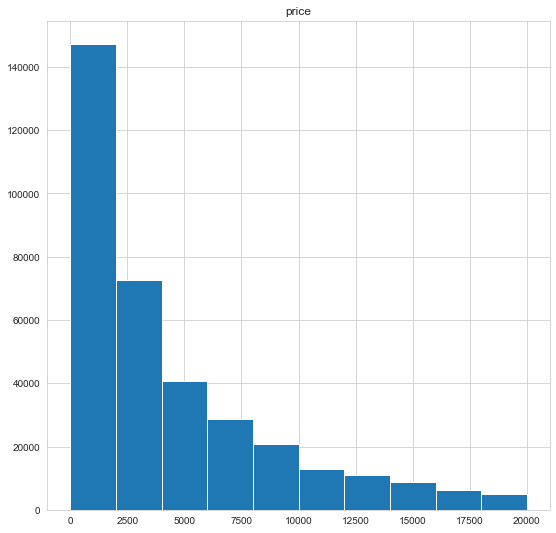

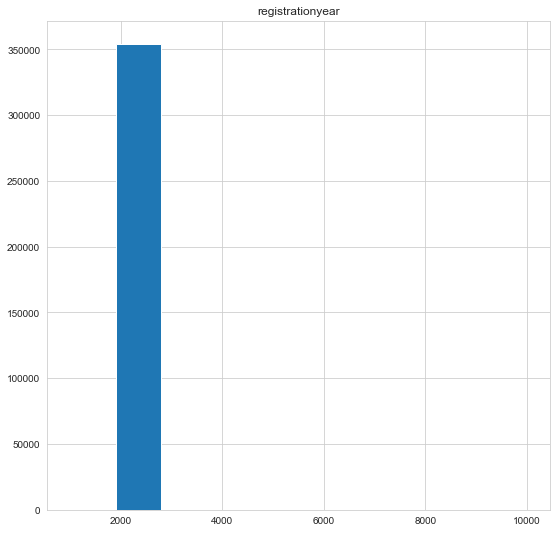

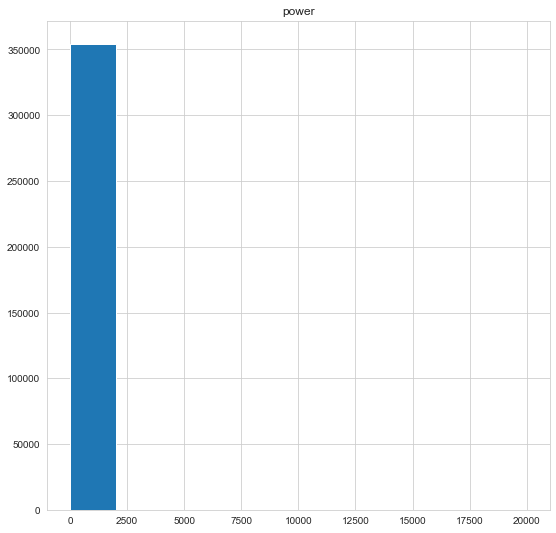

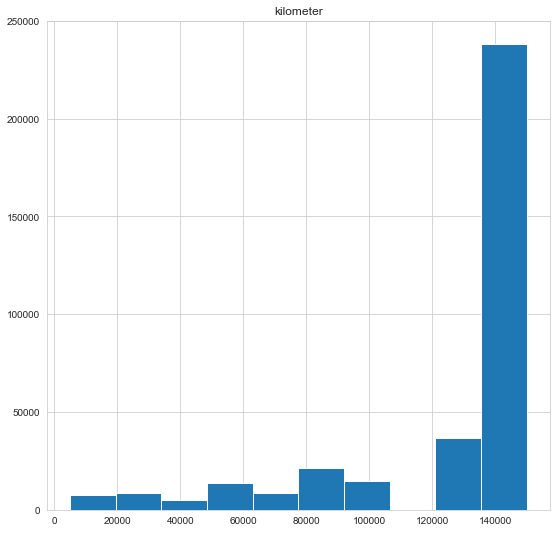

In [60]:
for column in num_features:
    df[column].hist(figsize=(9,9))
    plt.title(column)
    plt.show()
plt.show()

Видим, что в датафрейме имеются аномальные значения: год регистрации равен 0, 20000 лошадинных сил, цена в 0 евро, 9999 год регистрации. На графиках видно, что их совсем немного, что не скажется на качестве обучения. 

## Обучение моделей

In [13]:
cat_features = ["vehicletype", "gearbox", "model", "fueltype", "brand"]
num_features = ["power", "kilometer", "registrationyear"]

In [14]:
df_features.shape

(298264, 9)

#### Линейная регрессия

In [34]:
df_ohe = pd.get_dummies(df_features, drop_first=True)
df_ohe.shape

X = df_ohe.drop("price", axis=1)
y = df_ohe["price"]


numerical_columns = ["power", "kilometer", "registrationyear"]
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

In [35]:
%%time
lr_model = LinearRegression()
lr_model.fit(X, y)

CPU times: user 16.4 s, sys: 1.09 s, total: 17.5 s
Wall time: 5.86 s


LinearRegression()

In [36]:
%%time

y_pred = lr_model.predict(X)

print(f'RMSE Линейной регрессии = {(mean_squared_error(y, y_pred))**0.5}.')

RMSE Линейной регрессии = 3341.7959957211115.
CPU times: user 559 ms, sys: 292 ms, total: 851 ms
Wall time: 535 ms


#### Случайный лес

In [18]:
df_lbe = df_features.copy()

encoder = OrdinalEncoder()

encoded = encoder.fit_transform(df_lbe[cat_features])
df_lbe[cat_features] = encoded

df_lbe.head(2)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand
0,480,7.0,1993,1.0,0,116.0,150000,6.0,38.0
1,18300,2.0,2011,1.0,190,228.0,125000,2.0,1.0


In [19]:
X = df_lbe.drop("price", axis=1)
y = df_lbe["price"]

In [20]:
for n in [30, 50]:
    rf_model = RandomForestRegressor(n_estimators=n, n_jobs=-1, random_state=12345)
    mse = cross_val_score(
        rf_model, X, y, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(
        f"Среднее RMSE Случайного леса с {n} наблюдателями = {avg_rmse}."
    )
    print()

for n in [7, 15]:
    rf_model = RandomForestRegressor(
        n_estimators=30, max_depth=n, n_jobs=-1, random_state=12345
    )
    mse = cross_val_score(
        rf_model, X, y, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(
        f"Среднее RMSE Случайного леса с максимальной глубиной в {n} = {avg_rmse}."
    )
    print()

Среднее RMSE Случайного леса с 30 наблюдателями = 1974.0758476337267.

Среднее RMSE Случайного леса с 50 наблюдателями = 1965.1625362182128.

Среднее RMSE Случайного леса с максимальной глубиной в 7 = 2325.6100252513625.

Среднее RMSE Случайного леса с максимальной глубиной в 15 = 1946.19713170094.



In [37]:
%%time
best_rf_model = RandomForestRegressor(n_estimators = 50, max_depth=15, n_jobs=-1, random_state=12345)
best_rf_model.fit(X, y)

CPU times: user 8min 2s, sys: 1.32 s, total: 8min 4s
Wall time: 1min 5s


RandomForestRegressor(max_depth=15, n_estimators=50, n_jobs=-1,
                      random_state=12345)

In [38]:
%%time

y_pred = best_rf_model.predict(X)

print(f'RMSE лучшей модели Случайного леса = {(mean_squared_error(y, y_pred))**0.5}.')

RMSE лучшей модели Случайного леса = 1686.215391377454.
CPU times: user 3.25 s, sys: 366 ms, total: 3.62 s
Wall time: 1.14 s


#### LightgbmRegressor

In [23]:
for n in [30, 50]:
    lg_model = LGBMRegressor(n_estimators=n, random_state=12345)
    mse = cross_val_score(
        lg_model, X, y, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"RMSE LightGBM модели с {n} наблюдателями = {avg_rmse}.")
    print()


for n in [7, 15]:
    lg_model = LGBMRegressor(n_estimators=30, max_depth=n, random_state=234)
    mse = cross_val_score(
        lg_model, X, y, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"RMSE LightGBM модели с максимальной глубиной в {n} = {avg_rmse}.")
    print()  

'\nfor n in [30, 50]:\n    lg_model = LGBMRegressor(n_estimators=n, random_state=12345)\n    mse = cross_val_score(\n        lg_model, X, y, scoring="neg_mean_squared_error", cv=3\n    )\n    rmse = np.sqrt(mse * -1)\n    avg_rmse = np.sum(rmse) / len(rmse)\n    print(f"RMSE LightGBM модели с {n} наблюдателями = {avg_rmse}.")\n    print()\n\n\nfor n in [7, 15]:\n    lg_model = LGBMRegressor(n_estimators=30, max_depth=n, random_state=234)\n    mse = cross_val_score(\n        lg_model, X, y, scoring="neg_mean_squared_error", cv=3\n    )\n    rmse = np.sqrt(mse * -1)\n    avg_rmse = np.sum(rmse) / len(rmse)\n    print(f"RMSE LightGBM модели с максимальной глубиной в {n} = {avg_rmse}.")\n    print()\n'

In [24]:
%%time
best_lg_model = LGBMRegressor(n_estimators=50, max_depth=15, random_state=12345)
best_lg_model.fit(X, y)

'\n%%time\nbest_lg_model = LGBMRegressor(n_estimators=50, max_depth=15, random_state=12345)\nbest_lg_model.fit(X, y)\n'

In [25]:
%%time

y_pred = best_lg_model.predict(X)

print(f'RMSE лучшей LightGBM модели = {(mean_squared_error(y, y_pred))**0.5}.')


"\n%%time\n\ny_pred = best_lg_model.predict(X)\n\nprint(f'RMSE лучшей LightGBM модели = {(mean_squared_error(y, y_pred))**0.5}.')\n"

#### CatboostRegressor

In [41]:
X = df_features.drop("price", axis=1)
y = df_features["price"]


for n in [30, 50]:
    cb_model = CatBoostRegressor(
        iterations=n,
        learning_rate=1,
        random_seed=12345,
        silent=True,
        cat_features=cat_features,
    )
    mse = cross_val_score(
        cb_model, X, y, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"RMSE модели Catboost с {n} итерациями = {avg_rmse}.")
    print()

for n in [7, 15]:
    cb_model = CatBoostRegressor(
        iterations=30,
        learning_rate=1,
        depth=n,
        random_seed=12345,
        silent=True,
        cat_features=cat_features,
    )
    mse = cross_val_score(
        cb_model, X, y, scoring="neg_mean_squared_error", cv=3
    )
    rmse = np.sqrt(mse * -1)
    avg_rmse = np.sum(rmse) / len(rmse)
    print(f"RMSE Catboost модели с глубиной в {n} = {avg_rmse}.")
    print()

RMSE модели Catboost с 30 итерациями = 2020.9664123629766.

RMSE модели Catboost с 50 итерациями = 1985.0673739274107.

RMSE Catboost модели с глубиной в 7 = 2003.8593912387103.

RMSE Catboost модели с глубиной в 15 = 2011.0287526201025.



In [42]:
%%time
best_cb_model = CatBoostRegressor(iterations=50, learning_rate=1, depth=15, random_seed=12345, silent=True)
best_cb_model.fit(X, y, cat_features=cat_features)

CPU times: user 55 s, sys: 5.08 s, total: 1min
Wall time: 18.3 s


In [43]:
%%time
y_pred = best_cb_model.predict(X)

print(f'RMSE лучшей Catboost модели = {(mean_squared_error(y, y_pred))**0.5}.')

RMSE лучшей Catboost модели = 1533.877041383295.
CPU times: user 512 ms, sys: 6.66 ms, total: 519 ms
Wall time: 258 ms


## Анализ моделей

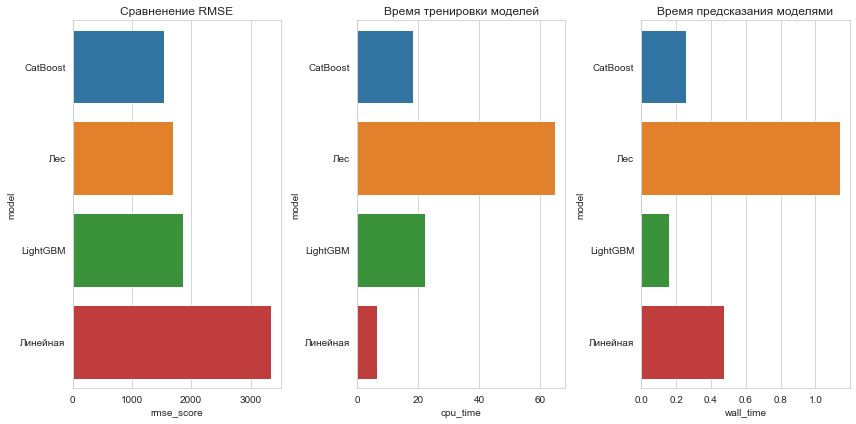

In [44]:
models = ["Линейная", "Лес", "LightGBM", "CatBoost"]
rmse_score = [3341.79, 1686.21, 1867.3, 1533.87]
cpu_time = [6.56, 65, 22.4, 18.3]
wall_time = [0.475, 1.14, 0.156, 0.258]

comparison = pd.DataFrame(
    data=zip(models, rmse_score, cpu_time, wall_time),
    columns=["model", "rmse_score", "cpu_time", "wall_time"],
)


fig, ax = plt.subplots(1, 3, figsize=(12, 6))
sns.set_style("whitegrid")


sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="rmse_score",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("Сравненение RMSE")
sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="cpu_time",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Время тренировки моделей")
sns.barplot(
    data=comparison.sort_values("rmse_score"),
    y="model",
    x="wall_time",
    orient="h",
    ax=ax[2],
)
ax[2].set_title("Время предсказания моделями")


plt.tight_layout()
plt.show()

По результатам исследования видно, что модель CatBoostRegressor показала наилучший результат по всем параметрам. Проверим ее на тестовой выборке.

In [46]:
X = df_features.drop("price", axis=1)
y = df_features["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12345
)

In [52]:
%%time
test_cb_model = CatBoostRegressor(iterations=50, learning_rate=1, depth=15, random_seed=12345, silent=True)
test_cb_model.fit(X_train, y_train, cat_features=cat_features)

CPU times: user 49.7 s, sys: 5.7 s, total: 55.4 s
Wall time: 18.7 s


In [53]:
%%time
y_pred = test_cb_model.predict(X_test)

print(f'RMSE Catboost модели на тестовой выборке = {(mean_squared_error(y_test, y_pred))**0.5}.')

RMSE Catboost модели на тестовой выборке = 2000.7191442665526.
CPU times: user 163 ms, sys: 5.4 ms, total: 168 ms
Wall time: 89.3 ms


## Вывод

Лучшей моделью оказалась CatboostRegressor с временем обучения 18.7 секунд, временем предсказания 0.089 секунды и значением **RMSE** - 2000.  

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей